In [1]:
import io
import requests
import zipfile

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def read_csv_from_zip(url, csv_name, **csv_kwargs):
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
        with zipf.open(csv_name) as f:
            return pd.read_csv(f, **csv_kwargs)

In [3]:
pop = read_csv_from_zip(
    'http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv',
    'API_SP.POP.TOTL_DS2_en_csv_v2_10224786.csv',
    skiprows=4,
)
metadata_pop = read_csv_from_zip(
    'http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv',
    'Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_10224786.csv',
)
gdp = read_csv_from_zip(
    'http://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.PP.CD?downloadformat=csv',
    'API_NY.GDP.PCAP.PP.CD_DS2_en_csv_v2_10224953.csv',
    skiprows=4,
)
life = read_csv_from_zip(
    'http://api.worldbank.org/v2/en/indicator/SP.DYN.LE00.IN?downloadformat=csv',
    'API_SP.DYN.LE00.IN_DS2_en_csv_v2_10224862.csv',
    skiprows=4,
)

In [4]:
pop.set_index('Country Code', verify_integrity=True, inplace=True)
metadata_pop.set_index('Country Code', verify_integrity=True, inplace=True)
gdp.set_index('Country Code', verify_integrity=True, inplace=True)
life.set_index('Country Code', verify_integrity=True, inplace=True)

In [5]:
year = 2016
year_str = str(year)

result = pd.DataFrame(index=pop.index)
result[['Country Name', 'POP']] = pop[['Country Name', year_str]]
result[['Region', 'IncomeGroup']] = metadata_pop.loc[metadata_pop.index.intersection(result.index), ['Region', 'IncomeGroup']]
result['GDP'] = gdp.loc[gdp.index.intersection(result.index), year_str]
result['LE'] = life.loc[life.index.intersection(result.index), year_str]

# Drop:
# 1. Aggregations of regions (we want only individual countries)
# 2. Countries without GDP data
# 3. Countries without life expectancy data
result.dropna(subset=['Region', 'GDP', 'LE'], inplace=True)

In [6]:
region2color = {
    'East Asia & Pacific': 'salmon',
    'Europe & Central Asia': 'palegreen',
    'Latin America & Caribbean': 'orange',
    'Middle East & North Africa': 'blue',
    'North America': 'pink',
    'South Asia': 'lightsalmon',
    'Sub-Saharan Africa': 'khaki',
}

colors = result['Region'].map(region2color)

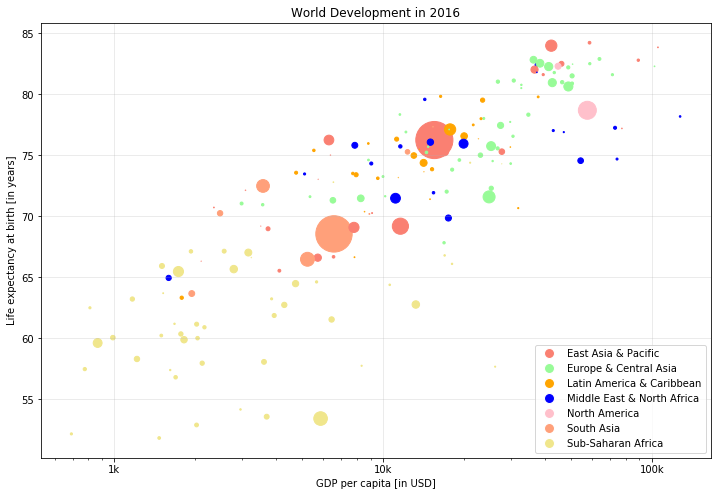

In [7]:
plt.figure(num=None, figsize=(12, 8))

plt.scatter(
    x=result['GDP'],
    y=result['LE'],
    s=(result['POP'] / 10 ** 6),
    c=colors,
)

plt.title('World Development in {}'.format(year))
plt.xlabel('GDP per capita [in USD]')
plt.xscale('log')
plt.xticks(
    [1000, 10000, 100000],
    ['1k', '10k', '100k'],
)
plt.ylabel('Life expectancy at birth [in years]')
plt.grid(alpha=0.3)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=region, markerfacecolor=color, markersize=10)
    for region, color in region2color.items()
]

plt.legend(handles=legend_elements, loc='lower right')

plt.show()